In [1]:
#Import modules

import pandas as pd

# import matplotlib.pyplot as plt
# %matplotlib inline

import dask.dataframe as dd
from dask.diagnostics import ProgressBar

from numpy import arange, log10

from functions import chunk, agg, finalize
tunique = dd.Aggregation('tunique', chunk, agg,finalize)
first = dd.Aggregation('first', chunk, agg,finalize)

## Monthly evolution

In [2]:
drive_path = './../../../../../../media/miglesia/Elements/export_france/data/type1/DP1610_MAASTRICHT1_1997_2013'

colnames = [u'YEAR', u'MONTH', u'FLUX', u'ID', u'DEPT', u'CN ID 8', u'CPA6',
       u'PYOD', u'PAYP', u'VAT', u'PRIFAC', u'DEVFAC', u'VFTE', u'VART', u'D_MASSE', u'MASSE', u'USUP', u'USUP_MT']

colname_no = dict(zip(colnames, range(18)))
# columns = [u'YEAR', u'MONTH', u'FLUX', u'ID', u'VART']
columns = [u'YEAR', u'MONTH', u'FLUX', u'ID', u'CN ID 8', 'PYOD', u'VART']

df_list = []

for y in range(2012, 2014):
    df_list += [dd.read_table(drive_path+'/DP1610_MAASTRICHT1_'+str(y)+'.txt', 
            usecols = map(colname_no.get, columns),
            delimiter = ';', header = None, dtype = {9: 'object'})]

data = dd.concat(df_list)
data.columns = columns
data['IMPORT'] = data['FLUX'] % 2


In [3]:
monthly_summary = data.groupby(['IMPORT','YEAR', 'MONTH', 'ID', 'CN ID 8']).agg(
    {'VART': 'sum', 'ID': tunique, 'CN ID 8': tunique})

In [4]:
with ProgressBar():
    out = monthly_summary.compute()

out.to_csv('monthly_summary.csv')

[########################################] | 100% Completed | 18min  1.6s


In [5]:
monthly_summary = pd.read_csv('./monthly_summary.csv')

# monthly_summary.loc[monthly_summary.IMPORT == 0]

/home/miglesia/anaconda2/lib/python2.7/site-packages/pandas/core/indexes/multi.py:1565: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if lab[key] == -1:
/home/miglesia/anaconda2/lib/python2.7/site-packages/pandas/core/indexes/multi.py:1568: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  retval.append(lev[lab[key]])


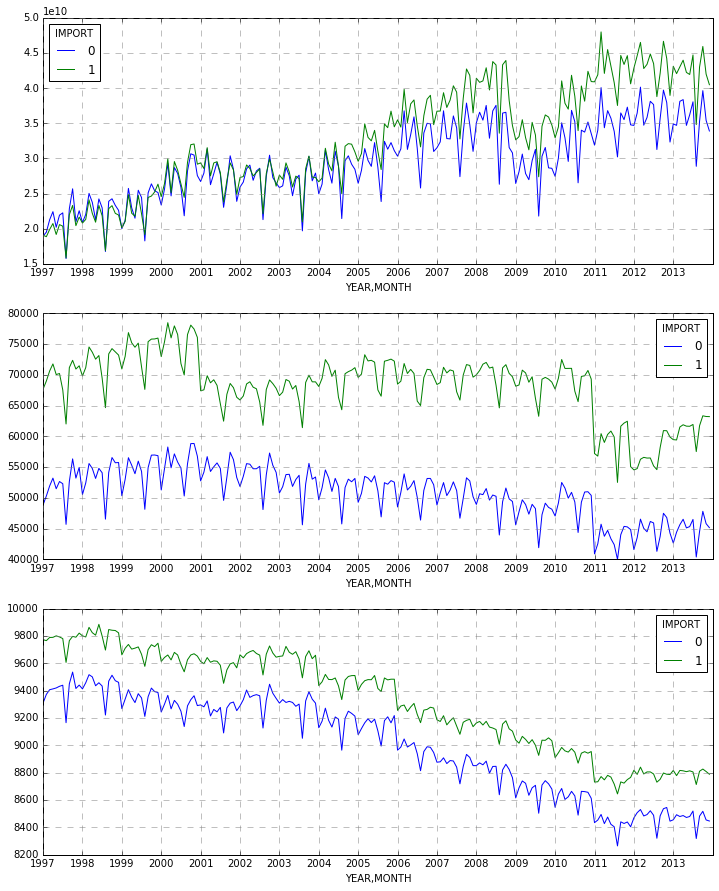

In [6]:
unstacked = monthly_summary.set_index(['IMPORT', 'YEAR', 'MONTH']).unstack(0)

fig, axs = plt.subplots(3, 1, figsize = (12, 15))
for i in [0, 1, 2]:
    
    ax = axs[i]
    unstacked[['VART', 'ID', 'CN ID 8'][i]].plot(ax = axs[i])

    ax.set_xticks(arange(0, 12*17+1, 12))
    ax.set_xticklabels(range(1997, 2014))
    ax.grid(linestyle='--', linewidth='0.5', color='gray')

In [8]:
firm_sizes = pd.read_csv('./../data/processed/firm_sizes.csv')
buyr_sizes = pd.read_csv('./../data/processed/buyr_sizes.csv')

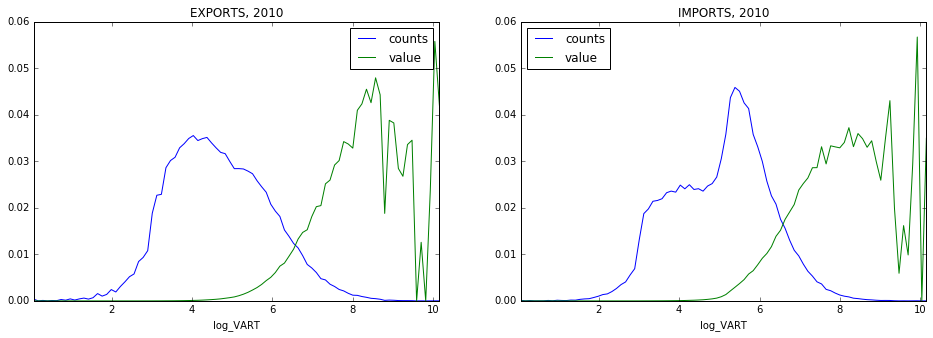

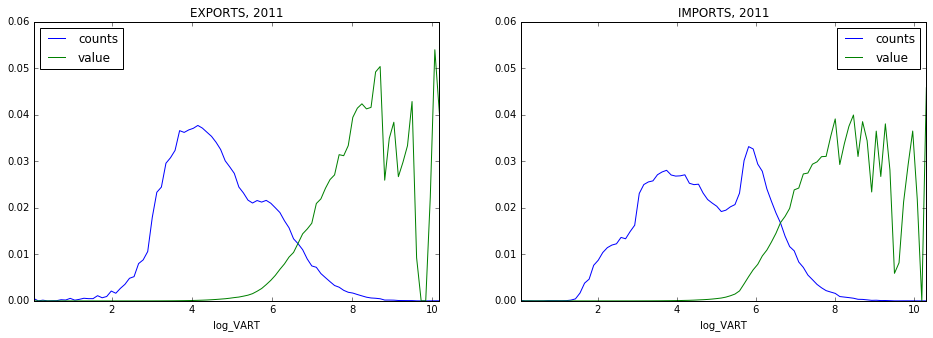

In [9]:
from numpy import inf, nan

fs_df = firm_sizes

for y in [2010, 2011]:
    fig, axs = plt.subplots(1, 2, figsize = (16, 5))
    for i in [0, 1]:
        fs_df_slice = fs_df.loc[(fs_df.YEAR == y) & (fs_df.IMPORT == i)].replace(-inf, nan).dropna()
        fs_df_slice['bin'], bins_x = pd.cut(fs_df_slice['log_VART'], 90, retbins=True)

        fs_ct_val = fs_df_slice.groupby('bin').agg({'ID': 'count', 'VART': sum}).rename(columns = {'ID': 'counts', 'VART': 'value'})

        fs_ct_val/=fs_ct_val.sum()
        ax = axs[i]
        fs_ct_val['log_VART'] = (bins_x[:-1] + bins_x[1:])/2.
        fs_ct_val.plot(x = 'log_VART', y = 'counts', ax = ax)
        fs_ct_val.plot(x = 'log_VART', y = 'value', ax = ax)
        ax.set_title('IMPORTS, '+str(y)) if i == 1 else ax.set_title('EXPORTS, '+str(y))
        ax.set_ylim(0, 0.06)